### Алгоритм 
#### 1 часть: подготовка к работе   
1.1. Установим необходимые библиотеки

In [1]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [2]:
pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 4.7 MB/s eta 0:00:00


In [3]:
pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 44.4 MB/s eta 0:00:00


In [4]:
pip install pydub

In [5]:
pip install pydub opencv-python-headless opuslib


  Preparing metadata (setup.py) ... done
  Created wheel for opuslib: filename=opuslib-3.0.1-py3-none-any.whl size=12564 sha256=44d5aaba479cabd78db658bdbb9bf82b37b2d72ff6fe38e1a1b00d24ac3c6c3e
  Stored in directory: /root/.cache/pip/wheels/94/54/3c/4cdec9effae0b0ed861a7623a7d2e2a9aa2d2cad179b9d71ea
Successfully built opuslib


1.2. Скачиваем выбранную CCS-модель

In [6]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [7]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

1.3. Монтируем Google-disk, на котором будем хранить вспомогательные материалы

In [8]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(ssd_model.state_dict(), 'ssd_model.pth')

Mounted at /content/drive


1.4. Подгружаем необходимые библиотеки

In [9]:
import telebot
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.patches as patches

import os
import speech_recognition as sr

from pydub import AudioSegment
import subprocess

import time
import json

#### 2 часть: реализация логики, которая будет обрабатывать данные, полученные от модели

In [10]:
def filter(uri):
    # Инициализация флага обнаружения объекта "cat"
    is_detected_cat = 0

    # Подготовка входных данных
    inputs = [utils.prepare_input(uri)]

    # Подготовка тензора для модели с учетом точности 'fp16'
    tensor = utils.prepare_tensor(inputs, precision == 'fp16')

    # Выполнение обнаружения объектов с использованием SSD-модели
    with torch.no_grad():
        detections_batch = ssd_model(tensor)

    # Декодирование результатов обнаружения
    results_per_input = utils.decode_results(detections_batch)

    # Выбор лучших результатов с пороговой уверенностью 0.20
    best_results_per_input = [utils.pick_best(results, 0.20) for results in results_per_input]

    with open("best_results_per_input.txt", 'w', encoding='utf-8') as file:
        for item in best_results_per_input:
          file.write(str(item) + '\n')

    # Получение словаря с соответствием классов меткам
    classes_to_labels = utils.get_coco_object_dictionary()

    with open("classes_to_labels.txt", 'w', encoding='utf-8') as file:
        for item in classes_to_labels:
            file.write(str(item) + '\n')

    # Итерация по изображениям с лучшими результатами
    for image_idx in range(len(best_results_per_input)):
        # Создание графика для визуализации результатов
        fig, ax = plt.subplots(1)

        # Отображение оригинального изображения
        image = inputs[image_idx] / 2 + 0.5
        ax.imshow(image)

        # Отображение прямоугольников вокруг обнаруженных объектов и меток с уверенностью
        bboxes, classes, confidences = best_results_per_input[image_idx]
        for idx in range(len(bboxes)):
            left, bot, right, top = bboxes[idx]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Проверка, является ли обнаруженный объект классом "cat"
            class_cat = classes_to_labels[classes[idx] - 1]
            if (class_cat == 'cat'):
                is_detected_cat = 1

            # Вывод метки класса и уверенности
            ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))

    # Сохранение отфильтрованного изображения
    plt.savefig("filtered_image.jpg")

    # Возвращение флага обнаружения объекта "cat"
    return is_detected_cat


#### 3 часть: создание телеграмм-бота через @BotFather

In [15]:
file_path = "/content/drive/MyDrive/Colab Notebooks/dl_project/token_1.txt"

In [16]:
with open(file_path, 'r') as file:
    bot_token = file.read().strip()

In [17]:
# Создаем экземпляр бота
bot = telebot.TeleBot(bot_token)

In [18]:
@bot.message_handler(commands=['start'])
def start_message(message):
    bot.send_message(message.chat.id, 'Привет! Пожалуйста, загрузи картинку.')


In [19]:
@bot.message_handler(content_types=['photo'])
def process_image(message):

    # Получаем информацию о картинке
    file_id = message.photo[-1].file_id
    file_info = bot.get_file(file_id)
    file_path = file_info.file_path

    # Скачиваем картинку
    downloaded_file = bot.download_file(file_path)

    # Сохраняем картинку на диск
    with open('image.jpg', 'wb') as f:
        f.write(downloaded_file)

    is_detected_cat = filter("image.jpg")

    # Отправляем пользователю преобразованное изображение
    with open('filtered_image.jpg', 'rb') as f:
        bot.send_photo(message.chat.id, f)

    if is_detected_cat == True:
        bot.reply_to(message, "Пришел твой кот. Кормушка открыта")


In [20]:
@bot.message_handler(content_types=['voice'])
def process_voice_message(message):
    # Получаем информацию о голосовом сообщении
    file_id = message.voice.file_id
    file_info = bot.get_file(file_id)
    file_path = file_info.file_path

    # Скачиваем голосовое сообщение
    downloaded_file = bot.download_file(file_path)

    # Сохраняем голосовое сообщение на диск
    voice_file_path = 'voice_message.ogg'
    with open(voice_file_path, 'wb') as f:
        f.write(downloaded_file)

    # Преобразование голосового сообщения в текст
    input_file = 'voice_message.ogg'
    audio = AudioSegment.from_file(input_file, format='ogg')

    # Конвертация в формат WAV
    output_file = 'audio.wav'
    audio.export(output_file, format='wav')


    recognizer = sr.Recognizer()
    with sr.AudioFile(output_file) as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data, language='ru')  # Здесь можно указать другой язык, если нужно
        print(text)

    # Отправляем текст пользователю
    bot.reply_to(message, text)

    # Удаляем временные файлы
    os.remove(output_file)



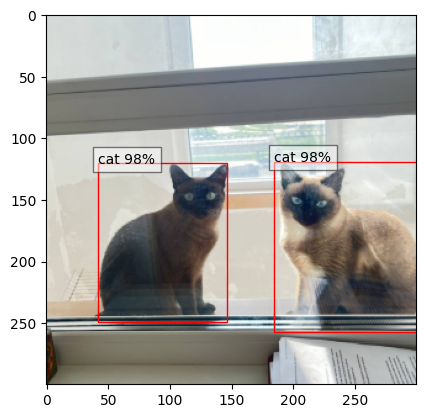

In [21]:
bot.polling()